In [1]:
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.callbacks import *
from keras import regularizers
from keras import optimizers
# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time

In [2]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [3]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)
#X:8761,X1:5869,X2:2892

In [4]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']
#Y3:valid_label,4177;Y4:test_label,2089

In [5]:
origin_dim = X1.shape[1]
epochs_layer = 30
epochs_whole = 80
batch_size = 32
h_dim1 = 16
h_dim2 = 8

In [6]:
def f2_score(label, predict):
    p = precision_score(label, predict)
    r = recall_score(label, predict)
    f2_score = 5*p*r / (4*p + r)
    return f2_score

In [7]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat),f2_score(Y,Yhat)]

In [8]:
def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize = (10,10))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下:
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [9]:
def pred_error(preds,x):
        #preds = preds.reshape(preds.shape[0],preds.shape[1])
        #x=x.reshape(x.shape[0],x.shape[1])
        errors = (x-preds)**2
        return preds, errors

In [10]:
def detect(preds,x, theta, window = 1, average=False, sys_theta = 0):
        preds, temp = pred_error(preds,x)
        #x=x.reshape(x.shape[0],x.shape[1])
        temp = (x-preds)**2
        #temp = pd.DataFrame(temp)
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()
            detection = errors > theta
        else:
            errors = temp.rolling(window=window).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta))

        return detection, errors

In [11]:
##### 设置网络参数 #####
p = 0.05  # 使大部分神经元的激活值（所有神经元的激活值的平均值）接近这个p值
beta = 3  # 控制KL散度所占的比重
lambda_val = 0.001  # weight decay
# 自定义正则项函数, 计算KL散度
def sparse_reg(activity_matrix):
        activity_matrix = K.softmax(activity_matrix, axis=0)  # 把激活值先用softmax归一化
        p_hat = K.mean(activity_matrix, axis=0)  # 将第j个神经元在batch_size个输入下所有的输出激活值取平均
        print('p_hat=', p_hat)
        KLD = p*(K.log(p/p_hat))+(1-p)*(K.log((1-p)/(1-p_hat)))  # 计算KL散度
        print('KLD=', KLD)
        return beta*K.sum(KLD)  # 所有神经元的KL散度相加并乘以beta

In [12]:
adam = tf.optimizers.Adam(lr = 0.001)

D:\anaconda\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')

In [14]:
##### 构建单个autoencoder #####
class AutoEncoderLayer():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()

    def build(self):
        self.input = Input(shape=(self.input_dim,))
        self.encode_layer = Dense(self.output_dim, activation='tanh')
        self.encoded = self.encode_layer(self.input)
        self.encoder = Model(self.input, self.encoded)

        self.decode_layer = Dense(self.input_dim, activation='tanh')
        self.decoded = self.decode_layer(self.encoded)

        self.autoencoder = Model(self.input, self.decoded)

In [15]:
# 构建堆叠DAE
class StackedAutoEncoder():
    def __init__(self, layer_list):
        self.layer_list = layer_list
        self.build()

    def build(self):
        out = self.layer_list[0].encoded
        for i in range(1, num_layers - 1):
            out = self.layer_list[i].encode_layer(out)
        self.model = Model(self.layer_list[0].input, out)

In [16]:
def train_layers(encoder_list=None, layer=None, epochs=None, batch_size=None):
    
    #预训练：逐层训练，当训练第layer个ae时，使用前（layer-1）个ae训练好的encoder的参数
    #:param encoder_list:
    #:param layer:
    #:param epochs:
    #:param batch_size:
    #:return:
    
    # 对前(layer-1)层用已经训练好的参数进行前向计算，ps:第0层没有前置层
    out = X1
    origin = X1
    if layer != 0:
        for i in range(layer):
            # print("encoder weight", str(i), ":", encoder_list[i].encoder.get_weights()[0])
            out = encoder_list[i].encoder.predict(out)

    encoder_list[layer].autoencoder.summary()
    encoder_list[layer].autoencoder.compile(optimizer=adam, loss='mse')

    # 训练第layer个ae
    layer = encoder_list[layer].autoencoder.fit(
        out,
        origin if layer == 0 else out,
        epochs=epochs,
        batch_size=batch_size,
        callbacks = [earlyStopping, lr_reduced],
        shuffle=True,
        verbose=2
    )
    plt.figure()
 


    loss = layer.history['loss']
    #val_loss = layer.history['val_loss']
 
    epochs = range(len(loss))
 

 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss',linestyle='-.')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Simple structure SAE Training layers loss')
    plt.legend()
 
    plt.show()

In [17]:
def train_whole(sae=None, epochs=None, batch_size=None):
    
    #用预训练好的参数初始化stacked ae的参数，然后进行全局训练优化
    #:param model:
    #:param epochs:
    #:param batch_size:
    #:return:
    
    # print("stacked sae weights:")
    # print(sae.model.get_weights())
    sae.model.summary()
    sae.model.compile(optimizer=adam, loss='mse')
    whole = sae.model.fit(
        X1,
        X1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks = [earlyStopping, lr_reduced],
        shuffle=True,
        validation_data=(X2,X2),
        verbose=2
    )
    plt.figure()
 


    loss = whole.history['loss']
    val_loss = whole.history['val_loss']
 
    epochs = range(len(loss))
 

 
    plt.figure()
 
    plt.plot(epochs, loss, 'y', label='Training loss',linestyle=':')
    plt.plot(epochs, val_loss, 'b', label='Validation loss',linestyle='-.')
    plt.title('Simple structure SAE Training and validation loss')
    plt.legend()
 
    plt.show()

Pre training:
level: 0
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 43)]              0         
                                                                 
 dense (Dense)               (None, 16)                704       
                                                                 
 dense_1 (Dense)             (None, 43)                731       
                                                                 
Total params: 1,435
Trainable params: 1,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
184/184 - 0s - loss: 0.1200 - lr: 0.0010 - 389ms/epoch - 2ms/step
Epoch 2/30
184/184 - 0s - loss: 0.0518 - lr: 0.0010 - 98ms/epoch - 531us/step
Epoch 3/30
184/184 - 0s - loss: 0.0324 - lr: 0.0010 - 100ms/epoch - 542us/step
Epoch 4/30
184/184 - 0s - loss: 0.0206 - lr: 0.0010 - 98ms/epoch

184/184 - 0s - loss: 0.0015 - lr: 0.0010 - 101ms/epoch - 547us/step
Epoch 24/30
184/184 - 0s - loss: 0.0015 - lr: 0.0010 - 107ms/epoch - 580us/step
Epoch 25/30
184/184 - 0s - loss: 0.0014 - lr: 0.0010 - 94ms/epoch - 510us/step
Epoch 26/30
184/184 - 0s - loss: 0.0014 - lr: 0.0010 - 95ms/epoch - 515us/step
Epoch 27/30
184/184 - 0s - loss: 0.0013 - lr: 0.0010 - 94ms/epoch - 510us/step
Epoch 28/30
184/184 - 0s - loss: 0.0013 - lr: 0.0010 - 94ms/epoch - 510us/step
Epoch 29/30
184/184 - 0s - loss: 0.0012 - lr: 0.0010 - 98ms/epoch - 531us/step
Epoch 30/30
184/184 - 0s - loss: 0.0012 - lr: 0.0010 - 99ms/epoch - 537us/step


<Figure size 432x288 with 0 Axes>

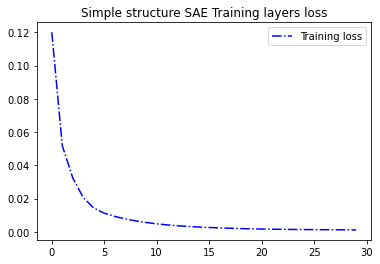

level: 1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
184/184 - 0s - loss: 0.0709 - lr: 0.0010 - 430ms/epoch - 2ms/step
Epoch 2/30
184/184 - 0s - loss: 0.0212 - lr: 0.0010 - 99ms/epoch - 537us/step
Epoch 3/30
184/184 - 0s - loss: 0.0152 - lr: 0.0010 - 91ms/epoch - 493us/step
Epoch 4/30
184/184 - 0s - loss: 0.0133 - lr: 0.0010 - 91ms/epoch - 493us/step
Epoch

184/184 - 0s - loss: 0.0094 - lr: 0.0010 - 90ms/epoch - 488us/step
Epoch 24/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 85ms/epoch - 461us/step
Epoch 25/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 75ms/epoch - 410us/step
Epoch 26/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 84ms/epoch - 458us/step
Epoch 27/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 77ms/epoch - 421us/step
Epoch 28/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 90ms/epoch - 488us/step
Epoch 29/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 91ms/epoch - 493us/step
Epoch 30/30
184/184 - 0s - loss: 0.0093 - lr: 0.0010 - 87ms/epoch - 475us/step


<Figure size 432x288 with 0 Axes>

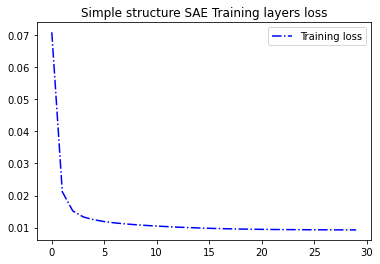

level: 2
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
184/184 - 0s - loss: 0.0352 - lr: 0.0010 - 334ms/epoch - 2ms/step
Epoch 2/30
184/184 - 0s - loss: 7.7866e-04 - lr: 0.0010 - 91ms/epoch - 495us/step
Epoch 3/30
184/184 - 0s - loss: 4.4385e-04 - lr: 0.0010 - 90ms/epoch - 488us/step
Epoch 4/30
184/184 - 0s - loss: 4.0287e-04 - lr: 0.0010 - 79ms/epoch - 432u

Epoch 23/30
184/184 - 0s - loss: 1.6133e-04 - lr: 0.0010 - 91ms/epoch - 495us/step
Epoch 24/30
184/184 - 0s - loss: 1.5758e-04 - lr: 0.0010 - 89ms/epoch - 482us/step
Epoch 25/30
184/184 - 0s - loss: 1.5416e-04 - lr: 0.0010 - 92ms/epoch - 499us/step
Epoch 26/30
184/184 - 0s - loss: 1.5120e-04 - lr: 0.0010 - 90ms/epoch - 488us/step
Epoch 27/30
184/184 - 0s - loss: 1.4847e-04 - lr: 0.0010 - 82ms/epoch - 448us/step
Epoch 28/30
184/184 - 0s - loss: 1.4561e-04 - lr: 0.0010 - 75ms/epoch - 410us/step
Epoch 29/30
184/184 - 0s - loss: 1.4399e-04 - lr: 0.0010 - 91ms/epoch - 493us/step
Epoch 30/30
184/184 - 0s - loss: 1.4079e-04 - lr: 0.0010 - 92ms/epoch - 499us/step


<Figure size 432x288 with 0 Axes>

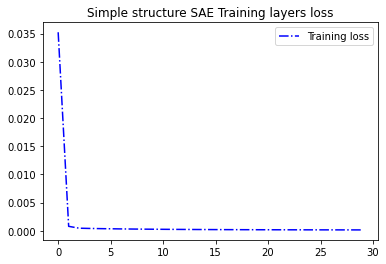

level: 3
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_6 (Dense)             (None, 43)                731       
                                                                 
 dense_7 (Dense)             (None, 16)                704       
                                                                 
Total params: 1,435
Trainable params: 1,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
184/184 - 0s - loss: 0.0047 - lr: 0.0010 - 346ms/epoch - 2ms/step
Epoch 2/30
184/184 - 0s - loss: 5.8578e-05 - lr: 0.0010 - 97ms/epoch - 526us/step
Epoch 3/30
184/184 - 0s - loss: 5.4610e-05 - lr: 0.0010 - 97ms/epoch - 526us/step
Epoch 4/30
184/184 - 0s - loss: 5.1171e-05 - lr: 0.0010 - 95ms/epoch - 

Epoch 23/30
184/184 - 0s - loss: 2.2541e-05 - lr: 0.0010 - 96ms/epoch - 520us/step
Epoch 24/30
184/184 - 0s - loss: 2.2194e-05 - lr: 0.0010 - 116ms/epoch - 629us/step
Epoch 25/30
184/184 - 0s - loss: 2.1652e-05 - lr: 0.0010 - 111ms/epoch - 602us/step
Epoch 26/30
184/184 - 0s - loss: 2.1138e-05 - lr: 0.0010 - 112ms/epoch - 607us/step
Epoch 27/30
184/184 - 0s - loss: 2.1140e-05 - lr: 0.0010 - 106ms/epoch - 575us/step
Epoch 28/30
184/184 - 0s - loss: 2.0566e-05 - lr: 0.0010 - 101ms/epoch - 547us/step
Epoch 29/30
184/184 - 0s - loss: 2.0051e-05 - lr: 0.0010 - 93ms/epoch - 505us/step
Epoch 30/30
184/184 - 0s - loss: 1.9585e-05 - lr: 0.0010 - 96ms/epoch - 520us/step


<Figure size 432x288 with 0 Axes>

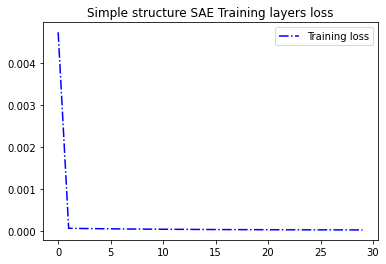

Whole training:
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 43)]              0         
                                                                 
 dense (Dense)               (None, 16)                704       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 43)                731       
                                                                 
Total params: 1,715
Trainable params: 1,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
184/184 - 0s - loss: 0.0567 - 

<Figure size 432x288 with 0 Axes>

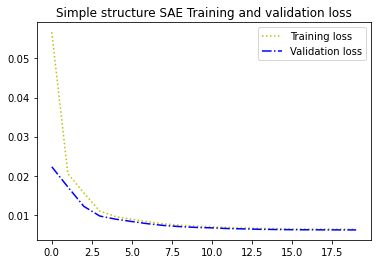

In [18]:
# 5层的stacked ae，实际上要使用4个ae，实例化4个ae
num_layers = 5
encoder_1 = AutoEncoderLayer(origin_dim, h_dim1)
encoder_2 = AutoEncoderLayer(h_dim1, h_dim2)

decoder_5 = AutoEncoderLayer(h_dim2, h_dim1)
decoder_6 = AutoEncoderLayer(h_dim1, origin_dim)
autoencoder_list = [encoder_1,encoder_2,decoder_5,decoder_6]

# 按照顺序对每一层进行预训练
print("Pre training:")
for level in range(num_layers - 1):
    print("level:", level)
    train_layers(encoder_list=autoencoder_list, layer=level, epochs=epochs_layer, batch_size=batch_size)


# 用训练好的4个ae构建stacked dae
stacked_ae = StackedAutoEncoder(autoencoder_list)
print("Whole training:")
# 进行全局训练优化
train_whole(sae=stacked_ae, epochs=epochs_whole, batch_size=batch_size)

In [19]:
##### 显示stacked dae重构后的效果 #####
X1_pre = stacked_ae.model.predict(X1)
X2_pre = stacked_ae.model.predict(X2)
X3_pre = stacked_ae.model.predict(X3)
X4_pre = stacked_ae.model.predict(X4)
print('X1: ',X1)
print('X1_pre: ',X1_pre)
print('X2: ',X2)
print('X2_pre: ',X2_pre)
print('X3: ',X3)
print('X3_pre: ',X3_pre)
print('X4: ',X2)
print('X4_pre: ',X4_pre)

X1:            L_T1      L_T2      L_T3      L_T4      L_T5      L_T6      L_T7  \
1170  0.488651  0.104012  0.765328  0.412776  0.353596  0.998148  0.445513   
579   0.637068  0.161366  0.928084  0.863257  0.248246  1.000000  0.942362   
2182  0.057699  0.743728  0.116650  0.597058  0.441985  1.000000  0.171913   
3608  0.732718  0.650633  0.390592  0.803850  0.849509  1.000000  0.663370   
2943  0.781443  0.942844  0.642789  0.411625  0.226870  0.191905  0.256424   
...        ...       ...       ...       ...       ...       ...       ...   
5734  0.663908  0.664919  0.067533  0.196580  0.586857  1.000000  0.517095   
5191  0.881324  0.625040  0.606332  0.622719  0.129357  0.345422  0.488734   
5390  0.904002  0.159823  0.587101  0.797103  0.615039  1.000000  0.488651   
860   0.279351  0.967521  0.414285  0.691745  0.573086  1.000000  0.846572   
7270  0.559075  0.660803  0.098045  0.392398  0.190758  1.000000  0.716468   

         F_PU1  S_PU1     F_PU2  ...    P_J300    P_J256  

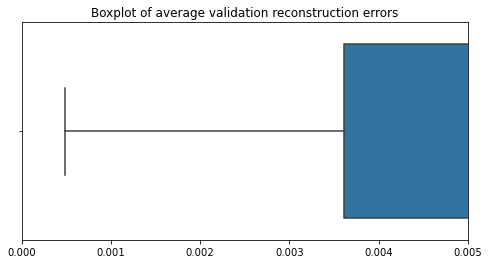

In [20]:
# perform detection

# get validation reconstruction errors
_, validation_errors = pred_error(X2_pre,X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta1 = validation_errors.mean(axis = 1).quantile(0.995)
theta2 = validation_errors.mean(axis = 1).quantile(0.994)

Yhat3, _ = detect(X3_pre,X3, theta = theta1 , window = 3, average=True)
Yhat4, _ = detect(X4_pre,X4, theta = theta2, window = 3, average=True)

In [21]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall','f2_score'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall  f2_score
test dataset 01  0.926263  0.561254  0.938095  0.400407   0.45225
test dataset 02  0.845859  0.361111  0.938144  0.223587  0.263768


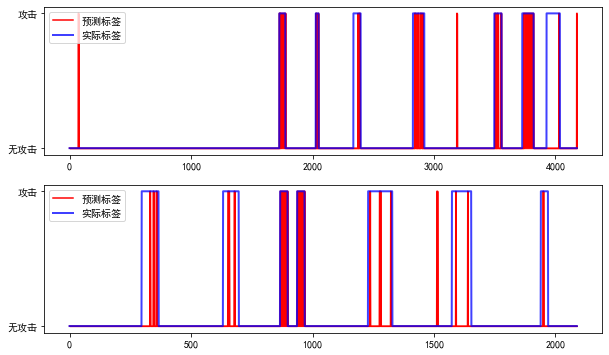

<Figure size 432x288 with 0 Axes>

In [22]:
# plot figures
font2 = {'family' : 'SimHei',#Times New Roman
        'weight' : 'normal',
        'size'   : 10,
            }
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 6,
            }
shade_of_gray = '0.75'
f_SAE2, axes = plt.subplots(2,figsize = (10,6))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
axes[0].plot(Yhat3, color = 'r', label = '预测标签')#shade_of_gray
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color='r')
axes[0].plot(Y3, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[0].set_title('validation set',font2,loc='left')
#axes[0].set_xlabel('Time/h',font2)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['无攻击','攻击'],font2)
axes[0].legend(loc='upper left',prop=font2)
#axes[0].legend(fontsize = 8, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

axes[1].plot(Yhat4, color = 'r', label = '预测标签')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color='r')
axes[1].plot(Y4, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[1].set_title('test set', font2,loc='left')
#axes[1].set_xlabel('Time/h',font2)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['无攻击','攻击'],font2)
axes[1].legend(loc='upper left',prop=font2)
#axes[1].legend(fontsize = 8, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.savefig("f_SAE2.2.png", dpi=1000, bbox_inches = 'tight')
plt.show()
plt.clf()

<Figure size 720x720 with 0 Axes>

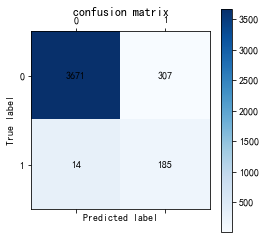

<Figure size 720x720 with 0 Axes>

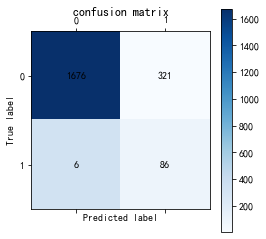

In [23]:
cm_plot(Y3,Yhat3)
cm_plot(Y4,Yhat4)